# Data Science Test @ RedPoints

## Part II. Churn prediction

*Hector Hernandez Coronado*

*Barcelona, 2020-11-26*

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.pipeline import Pipeline

import itertools
import matplotlib.pyplot as plt
import os
import random
import pickle
from scipy.sparse import csr_matrix

In [2]:
path = './'
filenames = [file for file in os.listdir(path) if '.csv' in file]
print(filenames)

['contracts_full.csv', 'clean_by_contract.csv']


## Load preprocessed dataset

In [3]:
contracts_raw = pd.read_csv('./clean_by_contract.csv', index_col=0, header=[0, 1])
contracts = contracts_raw.iloc[:,1:]
contracts['active'] = (contracts_raw['is_active']=='active').astype('int64')
contracts

brand piracy A_true                                      A_false  \
           unique unique cum_q0   cum_q1  cum_q2    cum_q3    cum_q4  cum_q0   
contractid                                                                     
16              0      1    0.0     0.00  5859.5  17356.00  399609.0     0.0   
21              1      0    0.0    48.25   314.5   4460.75  108047.0     0.0   
22              1      0    0.0     0.00    24.0    888.00    6854.0     0.0   
23              1      0   36.0   754.00  2483.0   5485.00  115338.0     0.0   
24              1      0   87.0  2994.00  7874.0  17748.00  385130.0     0.0   
...           ...    ...    ...      ...     ...       ...       ...     ...   
529             1      0   23.0   180.50   450.0    857.50   10528.0     0.0   
530             1      0   16.0    88.00   182.0    339.00    2111.0     0.0   
531             1      0  107.0   862.00  1996.0   4677.50   58372.0     0.0   
179_brand       1      0    0.0    26.00   171.0    434.50    9500.0     0.0   
179_piracy      0      1    0.0    26.00   171.0    434.50    9500.0     0.0   

                           ... automatization_B                        \
           cum_q1  cum_q2  ...           cum_q1 cum_q2 cum_q3  cum_q4   
contractid                 ...                                          
16            0.0     0.0  ...             0.00   0.00  0.000    0.00   
21           42.5  2412.0  ...             0.00   0.00  0.000    0.25   
22            0.0    10.0  ...             0.00   0.00  0.000    0.00   
23           27.0   148.0  ...             0.00   0.00  0.010    1.60   
24           18.0   125.0  ...             0.69   2.58  6.820  134.70   
...           ...     ...  ...              ...    ...    ...     ...   
529           0.0     1.0  ...             0.00   0.03  0.880   10.83   
530           0.0     0.0  ...             0.00   0.00  0.000    0.32   
531         682.5  1614.0  ...             0.00   0.00  0.005    0.18   
179_brand     0.0     0.0  ...             0.00   0.00  0.020   20.58   
179_piracy    0.0     0.0  ...             0.00   0.00  0.020   20.58   

           automatization_C                               active  
                     cum_q0 cum_q1 cum_q2  cum_q3  cum_q4         
contractid                                                        
16                     0.00   0.00   0.00  0.0000    0.00      1  
21                     0.00   0.00   0.00  0.0075    0.52      0  
22                     0.00   0.00   0.00  0.0000    0.04      0  
23                     0.00   0.37   2.78  7.4700  146.91      1  
24                     0.00   0.40   1.25  2.8800   61.23      1  
...                     ...    ...    ...     ...     ...    ...  
529                    0.00   0.00   0.00  0.0000    0.00      1  
530                    0.00   0.00   0.00  0.0000    0.00      0  
531                    0.08   0.78   1.87  3.6900   46.29      1  
179_brand              0.00   0.00   0.00  0.0000    0.00      1  
179_piracy             0.00   0.00   0.00  0.0000    0.00      1  

[498 rows x 103 columns]

## Plot features as function of date for both, active and inactive contracts

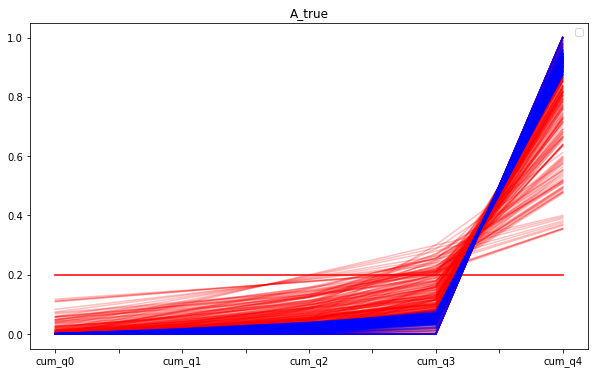

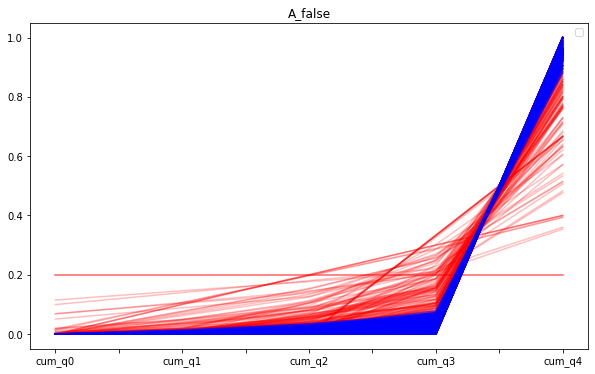

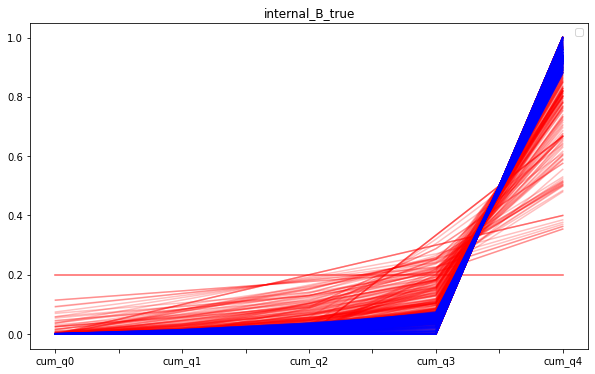

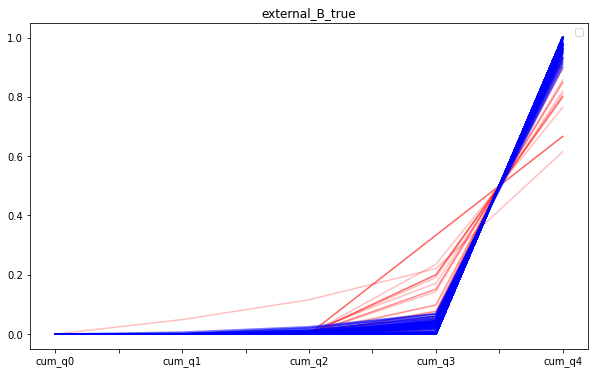

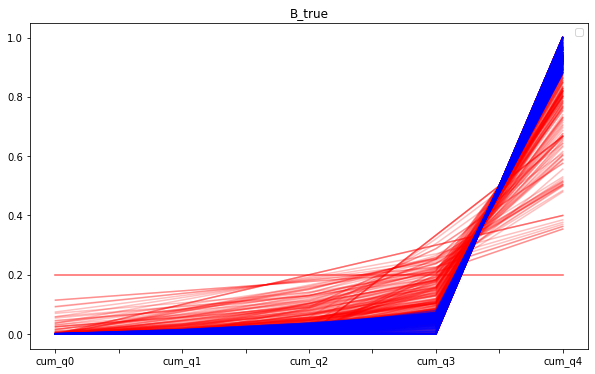

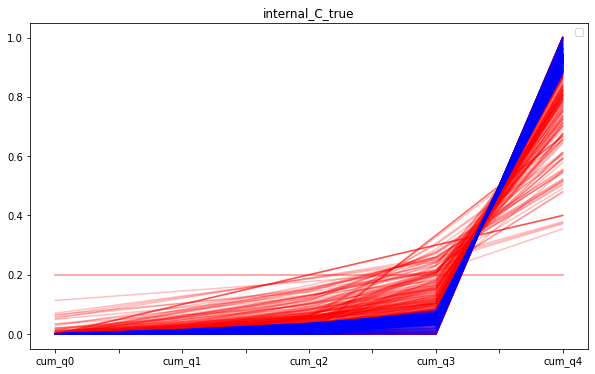

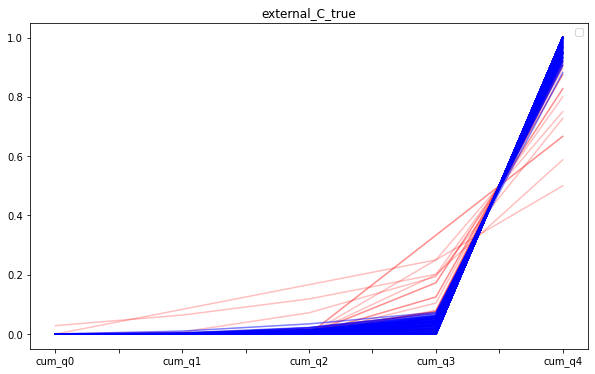

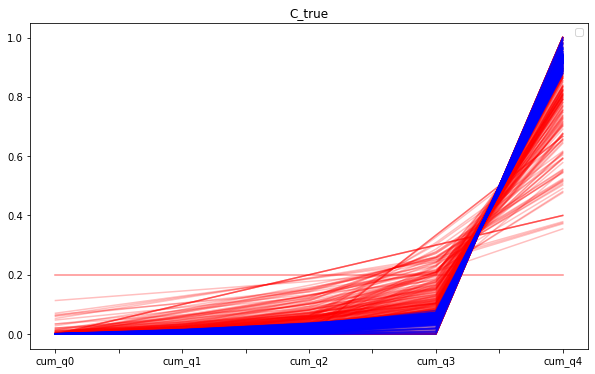

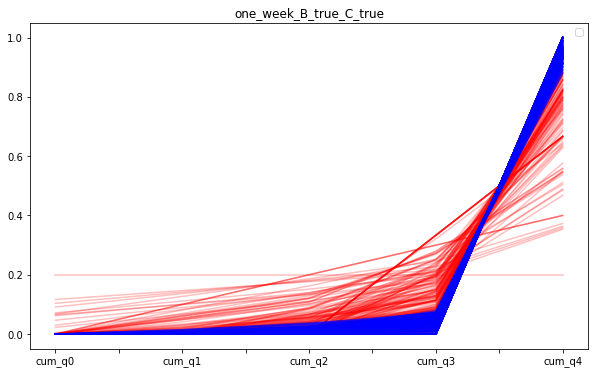

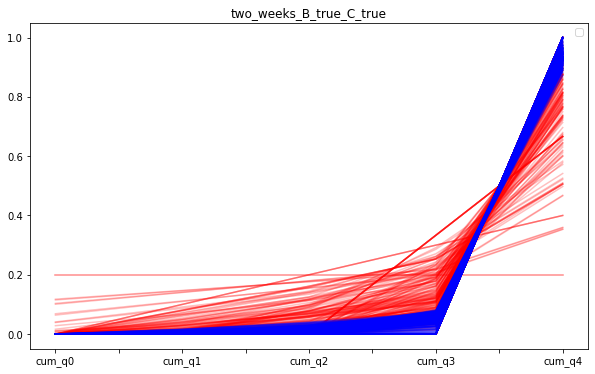

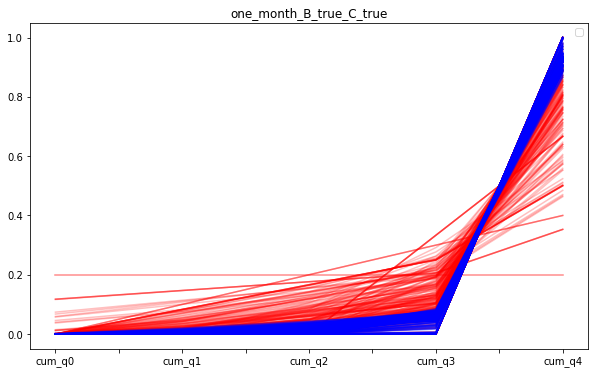

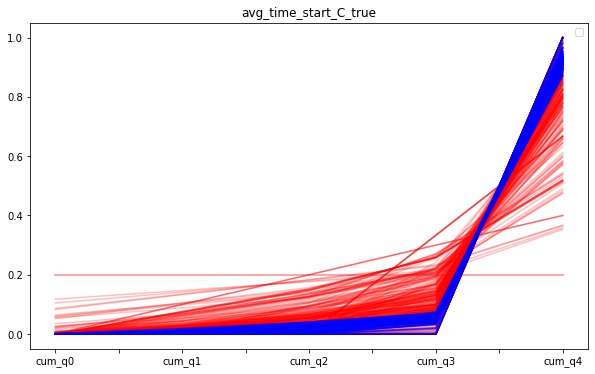

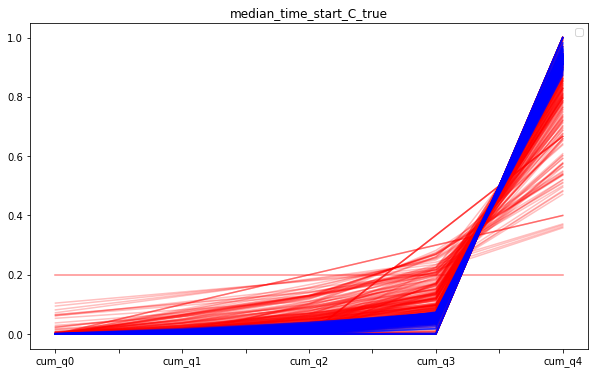

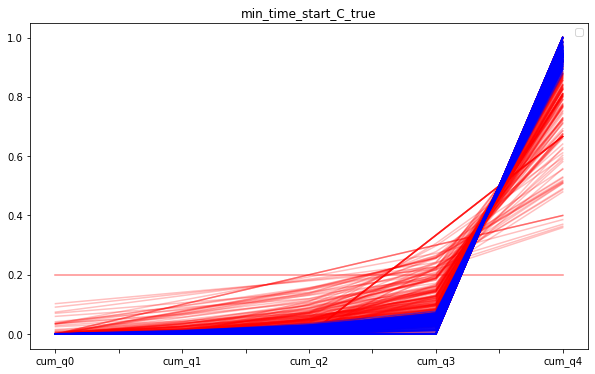

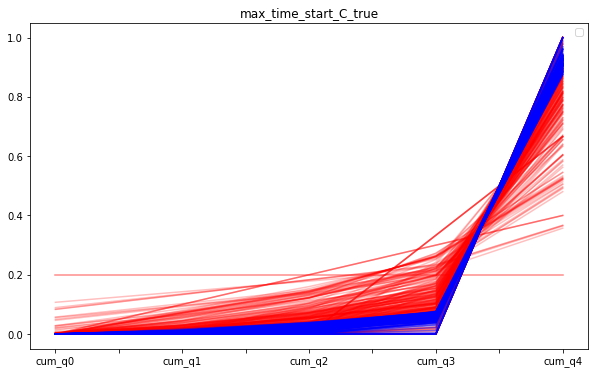

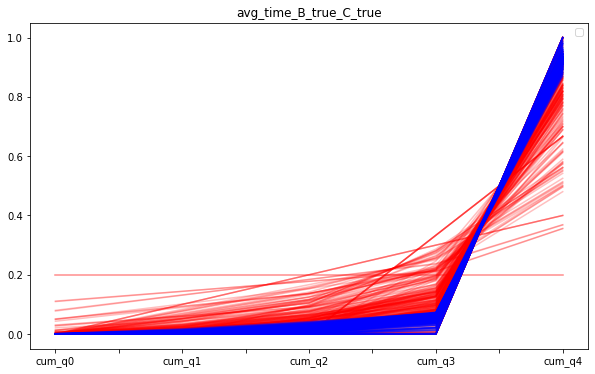

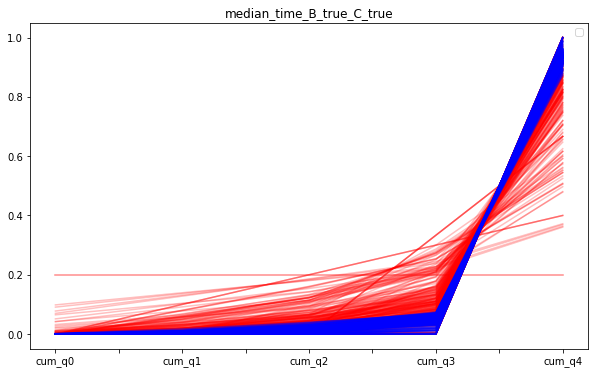

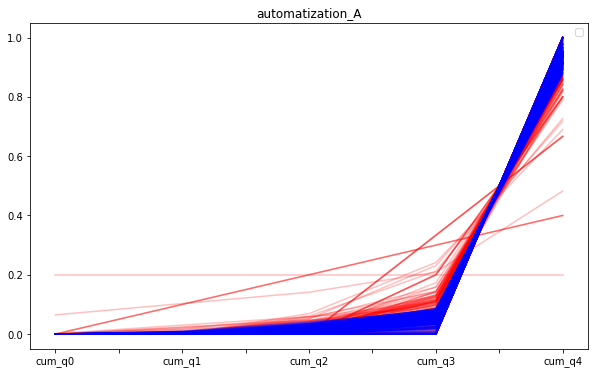

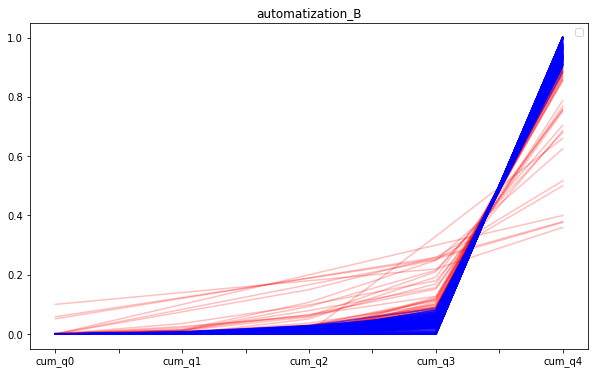

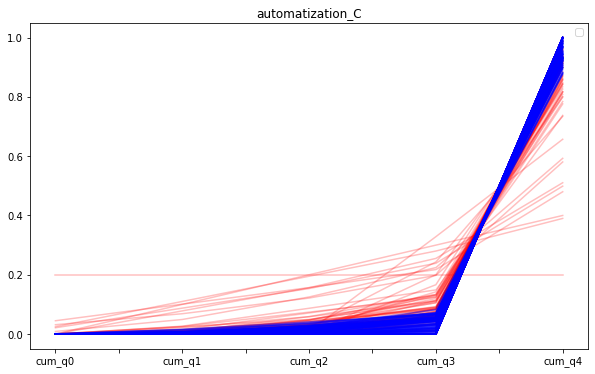

In [4]:
cols = contracts.columns[3:].droplevel(1).unique()[:-1]
active_filter = (contracts.active == 1)
inactive_filter =(contracts.active == 0)

for col in cols:
    actives = contracts[col][active_filter]
    inactives = contracts[col][inactive_filter]
    actives_norm = actives.div(actives.sum(axis=1),axis=0)
    inactives_norm = inactives.div(inactives.sum(axis=1),axis=0)
    ax = inactives_norm.T.plot(figsize=(12,6), c='r', alpha=.25)
    actives_norm.T.plot(figsize=(10,6), c='b', ax=ax, alpha=.5)
    plt.title(col)
    plt.legend('')
    plt.show()

In [12]:
contracts[contracts['A_true']['cum_q0'] == contracts['A_true']['cum_q4']]

brand piracy  A_true                                 A_false  \
           unique unique  cum_q0  cum_q1  cum_q2  cum_q3  cum_q4  cum_q0   
contractid                                                                 
113             1      0   156.0   156.0   156.0   156.0   156.0     0.0   
185             1      0   152.0   152.0   152.0   152.0   152.0     1.0   
195             1      0  1367.0  1367.0  1367.0  1367.0  1367.0   270.0   
196             1      0   603.0   603.0   603.0   603.0   603.0   170.0   
203             0      0     0.0     0.0     0.0     0.0     0.0     0.0   
204             0      0     0.0     0.0     0.0     0.0     0.0     0.0   
235             1      0   193.0   193.0   193.0   193.0   193.0     0.0   
340             1      0     0.0     0.0     0.0     0.0     0.0     0.0   
427             0      1     5.0     5.0     5.0     5.0     5.0     0.0   
430             1      0     0.0     0.0     0.0     0.0     0.0     0.0   
434             1      0   136.0   136.0   136.0   136.0   136.0     0.0   
485             0      0     0.0     0.0     0.0     0.0     0.0     0.0   
507             0      0     0.0     0.0     0.0     0.0     0.0     0.0   

                          ... automatization_B                       \
           cum_q1 cum_q2  ...           cum_q1 cum_q2 cum_q3 cum_q4   
contractid                ...                                         
113           0.0    0.0  ...              0.0    0.0    0.0    0.0   
185           1.0    1.0  ...              0.0    0.0    0.0    0.0   
195         270.0  270.0  ...              0.0    0.0    0.0    0.0   
196         170.0  170.0  ...              0.0    0.0    0.0    0.0   
203           0.0    0.0  ...              0.0    0.0    0.0    0.0   
204           0.0    0.0  ...              0.0    0.0    0.0    0.0   
235           0.0    0.0  ...              0.0    0.0    0.0    0.0   
340           0.0    0.0  ...              0.0    0.0    0.0    0.0   
427           0.0    0.0  ...              0.0    0.0    0.0    0.0   
430           0.0    0.0  ...              0.0    0.0    0.0    0.0   
434           0.0    0.0  ...              0.0    0.0    0.0    0.0   
485           0.0    0.0  ...              0.0    0.0    0.0    0.0   
507           0.0    0.0  ...              0.0    0.0    0.0    0.0   

           automatization_C                             active  
                     cum_q0 cum_q1 cum_q2 cum_q3 cum_q4         
contractid                                                      
113                    0.00   0.00   0.00   0.00   0.00      0  
185                    0.00   0.00   0.00   0.00   0.00      0  
195                    0.00   0.00   0.00   0.00   0.00      0  
196                    0.00   0.00   0.00   0.00   0.00      0  
203                    0.00   0.00   0.00   0.00   0.00      0  
204                    0.00   0.00   0.00   0.00   0.00      0  
235                    0.00   0.00   0.00   0.00   0.00      0  
340                    0.00   0.00   0.00   0.00   0.00      1  
427                    0.00   0.00   0.00   0.00   0.00      0  
430                    0.00   0.00   0.00   0.00   0.00      0  
434                    0.99   0.99   0.99   0.99   0.99      0  
485                    0.00   0.00   0.00   0.00   0.00      0  
507                    0.00   0.00   0.00   0.00   0.00      0  

[13 rows x 103 columns]

In [5]:

def plot_learning_curve(estimator, title, X, y):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features).

    y : array-like, shape (n_samples) or (n_samples, n_features).

    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].set_title(title)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y, cv=5, n_jobs=4,train_sizes=np.linspace(0.1, 1, 6), return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1)
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[0].plot(train_sizes, train_scores_mean, 'o-',
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', 
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


def plot_validation_curve(model):    
    '''
    Plots the score value as a function of regularization hyperparameter given the best values for the
    other possible hyperparameters.
    ------------------------------------------------------
    Input:
        model
        
    Output:
        plot
    '''
    fig, ax = plt.subplots(figsize=(15, 5))
    df = pd.DataFrame.from_dict(model.cv_results_)
    
    best_params = [v for k,v in model.best_params_.items() if k != 'LR__C']
    df_cv = df[(df['param_kbest__k'] == best_params[0]) 
               & df['param_scaler'].apply(lambda x: x == best_params[1])]
    df_cv = df_cv.set_index('param_LR__C')

    test_scores = df_cv['mean_test_score'].values
    test_std = df_cv['std_test_score'].values
    train_scores = df_cv['mean_train_score'].values
    train_std = df_cv['std_train_score'].values

        # plot validation curve
    ax.grid()
    df_cv[['mean_test_score', 'mean_train_score']].plot(ax=ax, logx=True)
    ax.scatter(df_cv.index, test_scores)
    ax.scatter(df_cv.index, train_scores)
    ax.fill_between(df_cv.index, test_scores - test_std, test_scores + test_std, alpha = 0.1)
    ax.fill_between(df_cv.index, train_scores - train_std, train_scores + train_std, alpha = 0.1)
    ax.set_xlabel('param_LR__C')
    ax.set_ylabel("Score")
    ax.set_title("Validation curve. Best parameters: {}".format(model.best_params_))
    
    return plt.show()


def train_classifier(df, test_size=0.3, random_state=42):
    '''
    Trains the logistic regression classifier to predict whether a 'contractid' is going to churn.
    ------------------------------------------------------------------
    Input:
        df. pd.DataFrame with the training examples.
        
    Output:
        LR classifier.
    '''
    ###############################
    ## Split train_test
    ## ----------------------------
    df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)
    ###############################
    ## featurize 
    ## ----------------------------
    ## targets
    y_train = np.asarray(df_train['active']).astype(int) 
    y_test = np.asarray(df_test['active']).astype(int)
    ## features
    X_train = np.asarray(df_train.drop(columns='active').values)
    X_test = np.asarray(df_test.drop(columns='active').values)   
    ###############################
    ## Model
    ## ----------------------------
    LR = LogisticRegression(penalty='l2', max_iter=10000, tol=0.001, n_jobs=-1, solver='saga', class_weight='balanced')
    
    param_grid = {'scaler': [StandardScaler(), RobustScaler()],
                  'kbest__k': [5, 10, 50],
                  'LR__C': np.logspace(-5, 5, 10)}
    pipeline = Pipeline(steps=[
                ('scaler', StandardScaler()), 
                ('kbest', SelectKBest()),
                ('LR', LR)], verbose=True)
    model = GridSearchCV(pipeline, param_grid, n_jobs=-1, scoring='roc_auc', return_train_score=True)
    model.fit(X_train, y_train)
    print("Best parameter (CV score=%0.3f):" % model.best_score_)
    print(model.best_params_)
    
    # Evaluating... validation    
    plot_validation_curve(model)
    plt.show()
    
    # learning curve
    #fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plot_learning_curve(model, "Learning Curves (LogReg)", X_train, y_train)
    plt.show()
    
    # prediction
    print("Predicting matching records...")
    y_pred = model.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred, labels=[1,0])
    np.set_printoptions(precision=4)

    # testing 
    print (classification_report(y_test, y_pred))
    # Plot non-normalized confusion matrix
    fig, ax = plt.subplots(figsize=(8,6))
    plot_confusion_matrix(model, X_test, y_test, cmap = plt.cm.Blues, ax=ax, normalize='true')
    plt.show()
    
    return model

# Training the model


Training model...


/home/h/.local/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 3) Processing kbest, total=   0.0s
[Pipeline] ................ (step 3 of 3) Processing LR, total=   0.0s
Best parameter (CV score=0.931):
{'LR__C': 100000.0, 'kbest__k': 5, 'scaler': RobustScaler()}


/home/h/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [17 32] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/h/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


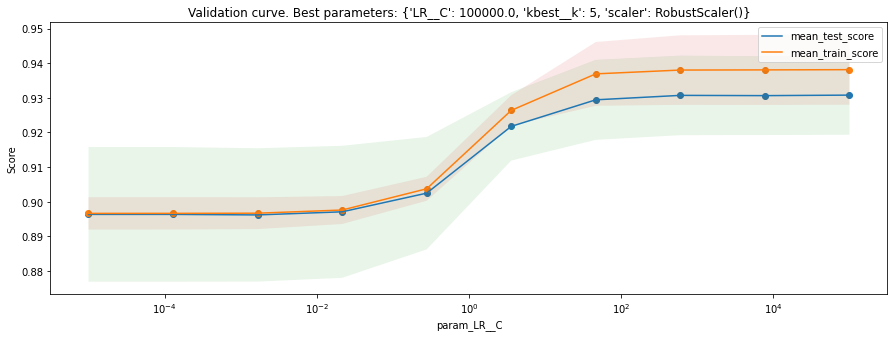

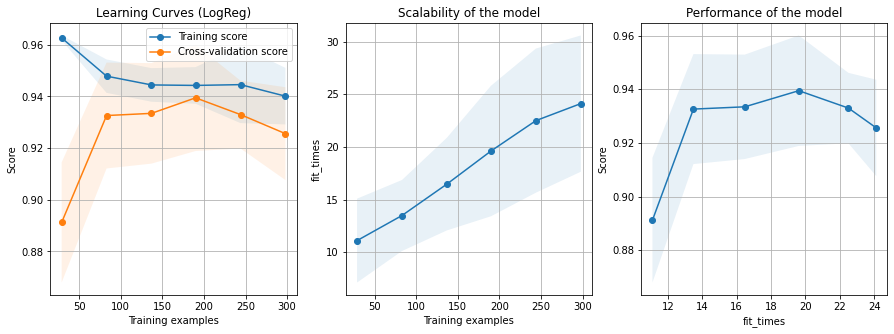

Predicting matching records...
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        75
           1       0.79      0.66      0.72        50

    accuracy                           0.79       125
   macro avg       0.79      0.77      0.78       125
weighted avg       0.79      0.79      0.79       125



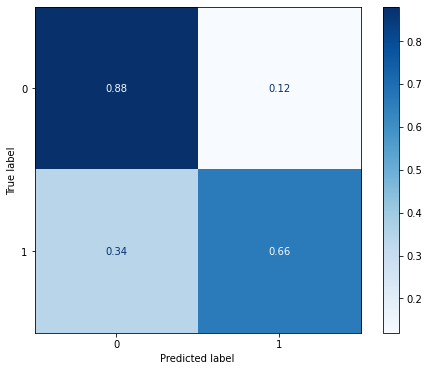

In [6]:
print('Training model...')
clf = train_classifier(contracts)

In [7]:
model = clf.best_estimator_
model.named_steps['LR'].coef_
best_idx = model.named_steps['kbest'].get_support(indices=True)
best_features = list(map(lambda x: x[0] + '_' + x[1], contracts.columns[best_idx].values))
best_features

['avg_time_start_C_true_cum_q4',
 'max_time_start_C_true_cum_q2',
 'max_time_start_C_true_cum_q3',
 'max_time_start_C_true_cum_q4',
 'avg_time_B_true_C_true_cum_q4']

avg_time_start_C_true_cum_q4        Score: 2.43
max_time_start_C_true_cum_q2        Score: -2.98
max_time_start_C_true_cum_q3        Score: 1.10
max_time_start_C_true_cum_q4        Score: 4.50
avg_time_B_true_C_true_cum_q4       Score: -2.02


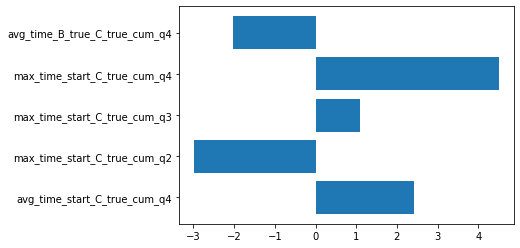

In [8]:
# get importance
importance = model.named_steps['LR'].coef_[0]
# summarize feature importance
for f,v in zip(best_features, importance):
    print('{:35} Score: {:.2f}'.format(f,v))
# plot feature importance
plt.barh([x for x in range(len(importance))], importance)
plt.yticks(np.arange(len(best_features)), best_features)
plt.show()